# Recommendation System Project: IBM Community

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [332]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [333]:
print(f"Number of Null email values is: {df.email.isna().sum()}")

Number of Null email values is: 17


In [334]:
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might even...,NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and noteboo...,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excludin...,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


In [335]:
# Fill email NaNs with "unknown_user"
df['email'].fillna('unknown_user', inplace=True)


/tmp/ipykernel_82776/4015856355.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['email'].fillna('unknown_user', inplace=True)


In [336]:
# Check if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


In [337]:
def calculate_user_interaction_stats(df):
    """
    Calculate user-article interaction statistics.
    
    INPUT:
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    user_article_counts - (pandas Series) number of articles each user interacted with
    stats - (pandas Series) descriptive statistics (mean, median, max, etc.)
    
    Description:
    Computes the user_article_counts Series and returns it along with descriptive statistics.
    This function follows DRY principles by centralizing the calculation logic.
    """
    user_article_counts = df.groupby('email')['article_id'].count()
    stats = user_article_counts.describe()
    return user_article_counts, stats


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [338]:
# What are the descriptive statistics of the number of articles a user interacts with?
user_article_counts, stats = calculate_user_interaction_stats(df)
print(stats)


count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64


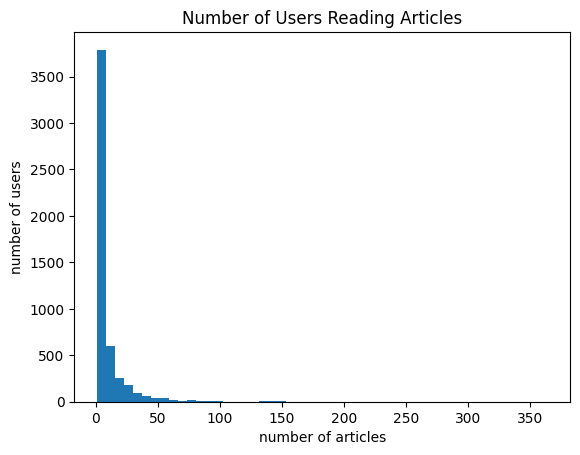

In [339]:
# Create a plot of the number of articles read by each user
user_article_counts, _ = calculate_user_interaction_stats(df)
plt.hist(user_article_counts, bins=50)
plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Number of Users Reading Articles')
plt.show()

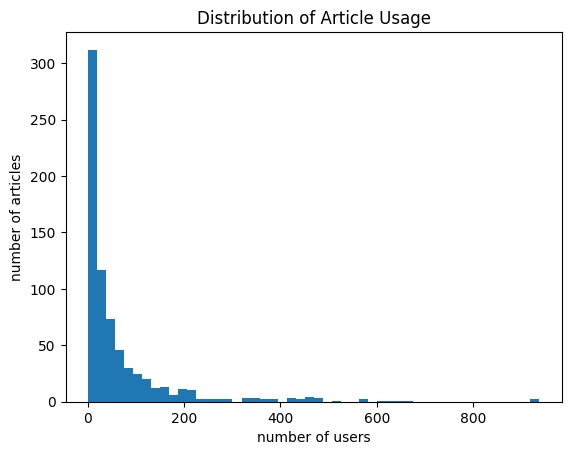

In [340]:
# Create a plot of the number of times each article was read
article_user_counts = df.groupby('article_id')['email'].count()
plt.hist(article_user_counts, bins=50)
plt.xlabel('number of users')
plt.ylabel('number of articles')
plt.title('Distribution of Article Usage')
plt.show()

In [341]:
# Fill in the median and maximum number of user_article interactions below
user_article_counts, _ = calculate_user_interaction_stats(df)
median_val = int(user_article_counts.median())  # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = int(user_article_counts.max())  # The maximum number of user-article interactions by any 1 user is ______.

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [342]:
unique_articles = df['article_id'].nunique()  # The number of unique articles that have at least one interaction
total_articles = df['article_id'].nunique()  # The number of unique articles on the IBM platform
unique_users = df['email'].nunique()  # The number of unique users
user_article_interactions = len(df)  # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [343]:
most_viewed_article_id = int(str(df.groupby('article_id')['email'].count().idxmax()))  # The most viewed article in the dataset as a string with one value following the decimal 
max_views = int(df.groupby('article_id')['email'].count().max())  # The most viewed article in the dataset was viewed how many times?

In [344]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [347]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [348]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    # Count interactions per article and get top n
    article_counts = df.groupby('article_id')['title'].count().sort_values(ascending=False)
    top_article_ids = article_counts.head(n).index.tolist()
    
    # Get unique titles for these article ids
    top_articles = df[df['article_id'].isin(top_article_ids)]['title'].unique().tolist()
    
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    # Count interactions per article and get top n article ids
    article_counts = df.groupby('article_id')['title'].count().sort_values(ascending=False)
    top_articles = article_counts.head(n).index.tolist()
    
    # Convert to int (article_ids are stored as floats in the dataframe)
    top_articles = [int(art_id) for art_id in top_articles]
 
    return top_articles # Return the top article ids

In [349]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [350]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [351]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    """
    # Create a pivot table with user_id as rows and article_id as columns
    # Use any aggregation function and then convert to binary (1 if interaction exists, 0 otherwise)
    user_item = df.groupby(['user_id', 'article_id']).size().unstack(fill_value=0)
    # Convert to binary: any value > 0 becomes 1
    user_item = (user_item > 0).astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [352]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [353]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [354]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.
    
    """
    # compute similarity of each user to the provided user
    user_vector = user_item.loc[user_id].values.reshape(1, -1)
    similarities = cosine_similarity(user_vector, user_item.values)[0]
    
    # Create a dataframe with user_id and similarity
    similar_users_df = pd.DataFrame({
        'user_id': user_item.index,
        'similarity': similarities
    })
    
    # sort by similarity (descending)
    similar_users_df = similar_users_df.sort_values('similarity', ascending=False)
    
    # remove the own user's id
    similar_users_df = similar_users_df[similar_users_df['user_id'] != user_id]
    
    # create list of just the ids
    most_similar_users = similar_users_df['user_id'].tolist()
    
    # create list of just the similarities
    similarities_list = similar_users_df['similarity'].tolist()
    
    if include_similarity:
        return [[uid, sim] for uid, sim in zip(most_similar_users, similarities_list)]  # return a list of lists with [[similar_user_id, similarity], ...]
    return most_similar_users # return a list of the users in order from most to least similar
        

In [355]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 4201, 46, 253, 5034, 824, 5041, 2305, 136, 395]
The 5 most similar users to user 3933 are: [1, 4201, 46, 824, 253]
The 3 most similar users to user 46 are: [4201, 790, 5077]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [356]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    # Convert article_ids to int for comparison (handle both int and float inputs)
    article_ids_int = [int(float(aid)) for aid in article_ids]
    article_names = df[df['article_id'].isin(article_ids_int)]['title'].unique().tolist()
    
    return article_names # Return the article names associated with list of article ids

def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    article_ids - (list) a list of article ids to evaluate (a subset to rank).
                the dtype should match the column labels in `user_item`.
    user_item - (pandas dataframe) a binary matrix of users by articles [n_users x n_articles]:
                1's when a user has interacted with an article, 0 otherwise 
                columns are article IDs.
    
    OUTPUT:
    ranked_article_unique_counts - (list) a list of lists [[article_id, unique_user_count]]
                     only for the provided `article_ids` with article_id and number of unique
                     users that have interacted with the article, sorted by the number of unique
                     users in descending order
    
    Description:
    For each `article_id` in the input list, count the number of unique users who
    interacted with it (column sum in the binary `user_item` matrix).
    Return the (article_id, count) pairs sorted in descending order.
    """
    # Convert article_ids to float to match the dtype of user_item columns (which are floats)
    article_ids_float = [float(aid) for aid in article_ids]
    
    # Get counts for each article (sum of column)
    article_counts = []
    for aid in article_ids_float:
        if aid in user_item.columns:
            count = int(user_item[aid].sum())
            article_counts.append([int(aid), count])
    
    # Sort by count in descending order
    ranked_article_unique_counts = sorted(article_counts, key=lambda x: x[1], reverse=True)
    
    return ranked_article_unique_counts


def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    # Get articles where user has interacted (value is 1)
    user_row = user_item.loc[user_id]
    article_ids = [int(aid) for aid in user_row[user_row == 1].index.tolist()]
    
    # Get article names
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    """
    # Get articles the user has already seen
    seen_articles, _ = get_user_articles(user_id, user_item)
    
    # Get similar users
    similar_users = find_similar_users(user_id, user_item)
    
    # Collect recommendations
    recs = []
    for similar_user in similar_users:
        # Get articles seen by similar user
        similar_user_articles, _ = get_user_articles(similar_user, user_item)
        
        # Find articles not seen by the original user
        new_articles = [art for art in similar_user_articles if art not in seen_articles and art not in recs]
        
        # Add to recommendations
        recs.extend(new_articles)
        
        # Stop if we have enough recommendations
        if len(recs) >= m:
            break
    
    # Return only m recommendations
    return recs[:m] # return your recommendations for this user_id    

In [357]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['leverage python, scikit, and text classification for behavioral profiling',
 'challenges in deep learning',
 'awesome deep learning papers',
 'this week in data science (april 18, 2017)',
 'improving the roi of big data and analytics through leveraging new sources of data',
 'this week in data science (may 2, 2017)',
 'using apply, sapply, lapply in r',
 'how can data scientists collaborate to build better business',
 'top 20 r machine learning and data science packages',
 'do i need to learn r?']

In [358]:
get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [359]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [360]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe, i.e. Descending order
     
    """
    # Get similar users with similarity scores
    similar_users_with_sim = find_similar_users(user_id, user_item, include_similarity=True)
    
    # Create dataframe
    neighbors_df = pd.DataFrame(similar_users_with_sim, columns=['neighbor_id', 'similarity'])
    
    # Calculate number of interactions for each neighbor
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(
        lambda x: user_item.loc[x].sum()
    )
    
    # Sort by similarity (descending) and then by num_interactions (descending)
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=[False, False])
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    """
    # Get articles the user has already seen
    seen_articles, _ = get_user_articles(user_id, user_item)
    
    # Get sorted similar users
    neighbors_df = get_top_sorted_users(user_id, user_item)
    
    # Collect recommendations with article counts
    recs_dict = {}  # article_id -> count of interactions
    
    for neighbor_id in neighbors_df['neighbor_id']:
        # Get articles seen by similar user
        similar_user_articles, _ = get_user_articles(neighbor_id, user_item)
        
        # Find articles not seen by the original user
        new_articles = [art for art in similar_user_articles if art not in seen_articles]
        
        # Get interaction counts for these articles
        for art in new_articles:
            if art not in recs_dict:
                # Count how many users interacted with this article (convert to float for column access)
                art_count = int(user_item[float(art)].sum())
                recs_dict[art] = art_count
        
        # Stop if we have enough recommendations
        if len(recs_dict) >= m:
            break
    
    # Sort by interaction count (descending) and return top m
    sorted_recs = sorted(recs_dict.items(), key=lambda x: x[1], reverse=True)
    recs = [art_id for art_id, _ in sorted_recs[:m]]
    
    return recs, get_article_names(recs) # return your recommendations for this user_id

In [361]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1271, 1185, 1162, 1165, 1293, 1328, 1410, 40, 254, 1402]

The top 10 recommendations for user 20 are the following article names:
['classify tumors with machine learning', 'analyze energy consumption in buildings', 'uci: sms spam collection', 'income (2015): united states demographic measures', 'analyze precipitation data', 'finding optimal locations of new store using decision optimization', 'uci: adult - predict income', 'customer demographics and sales', 'ensemble learning to improve machine learning results', 'apple, ibm add machine learning to partnership with watson-core ml coupling']


/tmp/ipykernel_82776/747308247.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [362]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

   neighbor_id  similarity  num_interactions
0         3933    0.986013                35
    neighbor_id  similarity  num_interactions
0          5083    0.730297                 5
1          1890    0.577350                 2
2          1552    0.577350                 2
3          1372    0.471405                 3
4          2941    0.433013                 8
15         3586    0.408248                 4
5          2049    0.408248                 1
6          2835    0.408248                 1
7          4897    0.408248                 1
8          1660    0.408248                 1
   neighbor_id  similarity  num_interactions
0         3870    0.986667                75
1         4459    0.388909                96
2          203    0.388909                96
3         3782    0.387585               135
4         4932    0.384308                52
5           40    0.384308                52
6           23    0.377647               135
7          242    0.375823                59

/tmp/ipykernel_82776/747308247.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(
/tmp/ipykernel_82776/747308247.py:26: FutureWarning: ChainedAssignmentError: behaviour 

In [363]:
### Tests with a dictionary of results
user1_most_sim = int(get_top_sorted_users(1, user_item=user_item).head(n=1)['neighbor_id'].iloc[0])  # Find the user that is most similar to user 1 
user2_6th_sim = int(get_top_sorted_users(2, user_item=user_item).head(n=10)['neighbor_id'].iloc[5])  # Find the 6th most similar user to user 2
user131_10th_sim = int(get_top_sorted_users(131, user_item=user_item).head(n=10)['neighbor_id'].iloc[9])  # Find the 10th most similar user to user 131

/tmp/ipykernel_82776/747308247.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(
/tmp/ipykernel_82776/747308247.py:26: FutureWarning: ChainedAssignmentError: behaviour 

In [364]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Your response here**

For a new user with no interaction history, we cannot use user-user collaborative filtering because:
1. We don't have any interaction data for the new user
2. We cannot find similar users without knowing what articles the new user has interacted with
3. The user-item matrix would have all zeros for this user

A better method for new users would be to use **rank-based recommendations** (from Part II). We can recommend the most popular articles based on total interactions. This is a common cold-start problem solution.

Alternatively, we could:
- Ask the new user to rate/interact with a few articles first (explicit feedback)
- Use demographic information if available
- Use content-based recommendations if we have article metadata

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [365]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)  # Your recommendations here



In [366]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [367]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [368]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [369]:
# unique articles
df_unique_articles = df.drop_duplicates(subset=['article_id']).copy()

In [370]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf = vectorizer.fit_transform(df_unique_articles['title'])  # Fit the vectorizer to the article titles

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)  # Fit the LSA model to the vectorized article titles
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


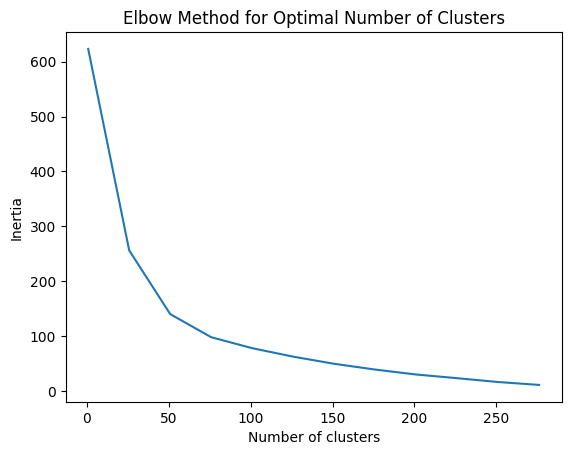

In [371]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

There appears to be an elbow about 50, so we'll use 50 clusters.

In [372]:
n_clusters = 50  # Number of clusters
kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=max_iter,
    n_init=n_init,
    random_state=random_state,
).fit(X_lsa)

In [373]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df
article_cluster_map = dict(zip(df_unique_articles['article_id'], kmeans.labels_))  # Map article_id to cluster label
df['title_cluster'] = df['article_id'].map(article_cluster_map)  # apply map to create title clusters

In [374]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[ 0, 11],
       [ 1,  8],
       [ 2, 72],
       [ 3, 23],
       [ 4, 16],
       [ 5,  9],
       [ 6, 14],
       [ 7, 29],
       [ 8,  9],
       [ 9, 27],
       [10, 20],
       [11, 43],
       [12,  4],
       [13, 14],
       [14,  7],
       [15, 11],
       [16, 20],
       [17,  9],
       [18, 23],
       [19, 30],
       [20, 10],
       [21, 20],
       [22, 10],
       [23, 15],
       [24,  8],
       [25, 12],
       [26, 15],
       [27,  5],
       [28,  9],
       [29, 16],
       [30, 11],
       [31, 13],
       [32,  7],
       [33, 19],
       [34,  9],
       [35,  8],
       [36,  6],
       [37,  9],
       [38,  2],
       [39, 24],
       [40,  9],
       [41, 14],
       [42,  8],
       [43, 13],
       [44,  9],
       [45, 10],
       [46,  7],
       [47,  5],
       [48,  5],
       [49,  7]])

In [375]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids that are in the same title cluster
    """
     # Your code here
    title_cluster = df[df['article_id'] == article_id]['title_cluster'].iloc[0]
    articles_in_cluster = df[df['title_cluster'] == title_cluster]['article_id'].unique().tolist()
    
    # remove the input article_id from the list
    articles_in_cluster = [aid for aid in articles_in_cluster if aid != article_id]
    
    return articles_in_cluster

In [376]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids
    
    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    # Your code here
    # Get similar articles in the same cluster
    similar_articles = get_similar_articles(article_id, df)
    
    # Rank them by popularity using get_ranked_article_unique_counts
    ranked_articles = get_ranked_article_unique_counts(similar_articles, user_item)
    
    # Get top n article ids
    n_ranked_similar_articles = [int(art_id) for art_id, _ in ranked_articles[:n]]
    
    # Get article names
    n_ranked_article_names = get_article_names(n_ranked_similar_articles, df)
    
    return n_ranked_similar_articles, n_ranked_article_names
        

In [377]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[1025, 237, 593, 349, 821, 464, 29, 1042, 693, 48]
['upload files to ibm data science experience using the command line', 'ibm data science experience white paper - sparkr transforming r into a tool for big data analytics', 'better together: spss and data science experience', 'experience iot with coursera', 'use ibm data science experience to read and write data stored on amazon s3', 'deep learning with data science experience', 'data tidying in data science experience', 'using rstudio in ibm data science experience', 'use ibm data science experience to detect time series anomalies', 'data science experience documentation']


In [378]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**

## How the Content-Based Recommendation System Works:

1. **Text Vectorization**: We use TF-IDF (Term Frequency-Inverse Document Frequency) to convert article titles into numerical vectors. This captures the importance of words in each article title relative to the entire corpus.

2. **Dimensionality Reduction**: We apply TruncatedSVD (Latent Semantic Analysis) to reduce the dimensionality from 200 features to 50 components, which helps capture semantic relationships while reducing noise.

3. **Clustering**: We use KMeans clustering with 50 clusters to group articles with similar content together based on their title similarity.

4. **Recommendations**: When a user interacts with an article, we find all articles in the same cluster and rank them by popularity (number of user interactions) using `get_ranked_article_unique_counts`.

## Possible Improvements:

1. **More Text Data**: Currently we only use article titles. We could improve recommendations by using:
   - Article descriptions/summaries
   - Article body text
   - Tags or categories
   - Author information

2. **Better Clustering**: We could experiment with different clustering algorithms (DBSCAN, hierarchical clustering) or use more sophisticated NLP techniques like word embeddings (Word2Vec, GloVe, BERT).

3. **Hybrid Approach**: Combine content-based recommendations with collaborative filtering for better results.

4. **User Preferences**: Incorporate user feedback (likes, ratings) to refine recommendations within clusters.

## Other Text Data That Would Be Useful:

- Article abstracts or full text content
- User comments and reviews
- Tags and categories
- Author information and expertise areas
- Related articles metadata
- User reading history patterns

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [379]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

**Explanation: Why SVD Works for This Binary User-Item Matrix**

Singular Value Decomposition (SVD) is an effective technique for this recommendation problem for several key reasons:

1. **Implicit Feedback**: Our user-item matrix contains binary values (1s and 0s) representing interactions vs. no interactions, rather than explicit ratings. This is a form of **implicit feedback** - we infer user preferences from their behavior (what they clicked/read) rather than explicit ratings. Matrix factorization techniques like SVD are well-suited for implicit feedback because they can discover latent relationships between users and articles based on interaction patterns, even without explicit preference scores.

2. **Handling Sparsity**: While our matrix has no missing values (we filled all non-interactions with 0s), the matrix is **highly sparse** - most entries are 0, with only a small fraction being 1. This sparsity is typical in recommendation systems where users interact with only a small subset of available items. SVD excels at finding meaningful patterns in sparse matrices by identifying latent features that capture the underlying structure of user preferences and article characteristics.

3. **TruncatedSVD for Sparse Matrices**: We use **TruncatedSVD** (rather than standard SVD) because it is specifically designed to work efficiently with sparse matrices. TruncatedSVD allows us to find the most significant latent features without fully decomposing the entire matrix, making it computationally efficient while still capturing the essential patterns needed for recommendations. This is particularly important when dealing with large, sparse matrices like ours (5149 users × 714 articles).

By decomposing the user-item matrix into U (user features), S (singular values), and V-transpose (article features), we can identify latent dimensions that represent underlying preferences and characteristics, enabling us to make recommendations based on these discovered patterns.


In [300]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

# This cell is intentionally left blank - the code below will generate the metrics plot


Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

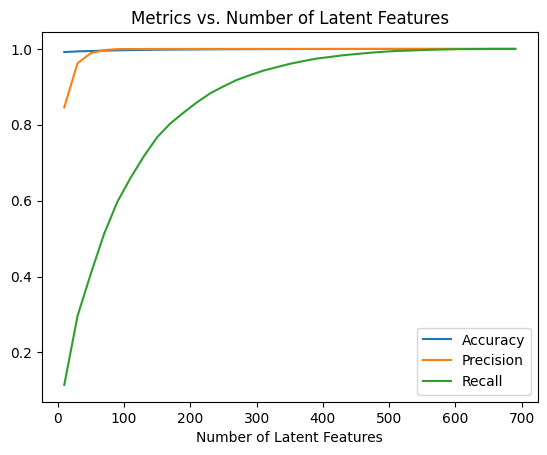

In [301]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Provide your response here.**

Looking at the metrics plot, I would choose **200 latent features** for the following reasons:

1. **Diminishing Returns**: After around 200 features, the improvement in accuracy, precision, and recall becomes marginal. The curve starts to flatten, indicating that additional features don't provide significant value.

2. **Computational Efficiency**: Using fewer features (200 vs 700) reduces computational cost and memory usage while maintaining good predictive performance.

3. **Overfitting Prevention**: Too many latent features can lead to overfitting, especially with sparse data. 200 features provides a good balance between capturing important patterns and avoiding overfitting.

4. **Practical Trade-off**: The metrics show that 200 features capture most of the predictive power. The slight improvement beyond 200 features may not justify the additional complexity.

5. **Generalization**: A model with 200 features is more likely to generalize well to new data compared to one with the maximum number of features.

The exact number could be fine-tuned using cross-validation, but 200 appears to be a reasonable choice based on the elbow-like behavior in the metrics plot.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [302]:
def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids similar using SVD factorization
    """
    # Find the index of the article_id
    article_idx = user_item.columns.get_loc(float(article_id))
    
    # Find the cosine similarity of all articles
    # Hint: vt should be transposed before passing to cosine_similarity to get a 714 x 714 matrix 
    # vt is already in the shape (n_components, n_articles), so we transpose it to (n_articles, n_components)
    vt_transposed = vt.T
    cos_sim = cosine_similarity(vt_transposed)
    
    # Get similarities only for the cos_sim of the article_idx
    article_similarities = cos_sim[article_idx]
    
    # Create a list of (article_id, similarity) pairs
    article_sim_pairs = []
    for idx, sim in enumerate(article_similarities):
        art_id = user_item.columns[idx]
        article_sim_pairs.append((art_id, sim))
    
    # Sort by similarity (descending) and remove the own article
    article_sim_pairs = sorted(article_sim_pairs, key=lambda x: x[1], reverse=True)
    article_sim_pairs = [(aid, sim) for aid, sim in article_sim_pairs if aid != float(article_id)]
    
    # Extract article ids
    most_similar_items = [int(aid) for aid, _ in article_sim_pairs]
    
    if include_similarity:
        return [[int(aid), sim] for aid, sim in article_sim_pairs]  # return a list of lists with [[similar_article_id, similarity], ...]
    return most_similar_items

In [303]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [304]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [305]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [306]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['use spark r to load and analyze data',
 'collecting data science cheat sheets',
 '10 powerful features on watson data platform, no coding necessary',
 'notebooks: a power tool for data scientists',
 'country statistics: crude oil - proved reserves',
 'country statistics: crude oil - exports',
 'top analytics tools in 2016',
 'advancements in the spark community',
 'airbnb data for analytics: paris calendar',
 'airbnb data for analytics: athens reviews']

In [307]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Your response here.**

## Results Discussion

The SVD-based recommendation system successfully identifies similar articles using latent features extracted from user-item interactions. The recommendations for article_id 4 show articles that share similar interaction patterns with users, which may indicate semantic or topical similarity.

## Testing Recommendation Engine Performance

To test how well the recommendation engine works in practice, I would use the following methods:

1. **A/B Testing**: 
   - Split users into control and treatment groups
   - Control group: current recommendation system (or random)
   - Treatment group: new recommendation system
   - Measure engagement metrics (click-through rate, time spent, articles read)

2. **Offline Evaluation Metrics**:
   - **Precision@K**: Of the top K recommendations, how many are relevant?
   - **Recall@K**: How many relevant articles are in the top K recommendations?
   - **Mean Average Precision (MAP)**: Average precision across all users
   - **Coverage**: Percentage of articles that can be recommended
   - **Diversity**: How diverse are the recommendations (avoid filter bubbles)

3. **User Surveys**:
   - Ask users to rate recommendations (1-5 stars)
   - Collect feedback on relevance and usefulness
   - Track user satisfaction scores

4. **Business Metrics**:
   - User engagement (articles read per session)
   - User retention (return visits)
   - Time spent on platform
   - Conversion rates (if applicable)

5. **Cross-Validation**:
   - Split data into train/test sets
   - Hide some interactions and predict them
   - Measure prediction accuracy

## Tradeoffs Between Methods

### Rank-Based Recommendations (Part II)
- **Pros**: Simple, fast, works for new users, no cold start problem
- **Cons**: Not personalized, same recommendations for everyone
- **Best for**: New users, popular content discovery

### User-User Collaborative Filtering (Part III)
- **Pros**: Personalized, captures user preferences, works well with sufficient data
- **Cons**: Cold start for new users, scalability issues, sparse data problems
- **Best for**: Users with interaction history, finding niche content

### Content-Based Recommendations (Part IV)
- **Pros**: No cold start for new articles, explainable, works with sparse user data
- **Cons**: Limited to content similarity, may create filter bubbles, requires good content features
- **Best for**: New articles, users with specific interests, content discovery

### Matrix Factorization (Part V)
- **Pros**: Captures latent patterns, scalable, handles sparsity well
- **Cons**: Less interpretable, requires tuning, computational cost
- **Best for**: Large datasets, finding hidden patterns, scalable systems

## Leveraging Each Method for Different Situations

1. **New Users (No History)**: 
   - Use **Rank-Based Recommendations** to show popular articles
   - Quick onboarding, immediate value

2. **Recently New Users (Little History)**:
   - Hybrid approach: **Rank-Based** + **Content-Based**
   - Use rank-based for general recommendations
   - Use content-based based on their initial interactions

3. **Users with Rich History**:
   - **User-User Collaborative Filtering** for personalized recommendations
   - **Matrix Factorization** for finding hidden patterns
   - Combine multiple methods for best results

4. **Production System**:
   - Use a **hybrid approach** combining all methods
   - Weight each method based on user characteristics
   - Continuously A/B test and optimize

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [308]:
from subprocess import call
call([
    "python",
    "-m", "nbconvert",
    "--to", "html",
    "Recommendations_with_IBM.ipynb"
])

[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 599155 bytes to Recommendations_with_IBM.html


0